GPT2 Model evaluation and fine tuning using Optuna

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requir

In [ ]:
from datasets import load_dataset
dataset_dialog = load_dataset("knkarthick/dialogsum")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
print(dataset_dialog)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


In [ ]:
dataset_dialog['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [ ]:
test_dataset= dataset_dialog['test']

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setting the pad_token as same as the eos_token
tokenizer.pad_token = tokenizer.eos_token

# to make sure the models embedding size is adjusted
model.resize_token_embeddings(len(tokenizer))

# Setting left padding in order to correct the generation behaviour
tokenizer.padding_side = "left"
model.to(device)

def generate_summary_batch(examples):
    input_texts = examples['dialogue']
    inputs = tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # generating summaries
    with torch.no_grad():
        output_ids = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=150, num_beams=4, early_stopping=True, pad_token_id=tokenizer.pad_token_id)

    # Decoding the generated output and converting id to text
    summaries = [tokenizer.decode(g, skip_special_tokens=True) for g in output_ids]

    return {"generated_summary": summaries}

# testing summary generation
batch_size = 8
test_dataset = test_dataset.map(generate_summary_batch, batched=True, batch_size=batch_size)
for i in range(3):
    print(f"Dialogue: {test_dataset[i]['dialogue']}")
    print(f"Generated Summary: {test_dataset[i]['generated_summary']}")
    print("-" * 80)


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dialogue: #Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.
#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?
#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.
#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.
#Person1#: They will just have to change their communication methods. I don't want any - one using Instant Messaging in this office. It wastes too much time! Now, please continue with th

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=7950fe232d6c2b359bb47a9ab51b21d48a688d1d125c6a16fd79cec8b68e080d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
!pip install bert_score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def calculate_metrics(reference, hypothesis):
    metrics = {}

    reference_tokens = nltk.word_tokenize(reference)
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    smooth_fn = SmoothingFunction().method1 #BLEU
    metrics['BLEU'] = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    metrics['ROUGE-1'] = rouge_scores['rouge1'].fmeasure
    metrics['ROUGE-2'] = rouge_scores['rouge2'].fmeasure
    metrics['ROUGE-L'] = rouge_scores['rougeL'].fmeasure
    metrics['METEOR'] = meteor_score([reference_tokens], hypothesis_tokens)
  cs['BERTScore'] = F1.mean().item()

    # BERTScore
    P, R, F1 = bert_score([hypothesis], [reference], lang='en', model_type='bert-base-uncased', verbose=False)
    metrics['BERTScore_P'] = P.mean().item()
    metrics['BERTScore_R'] = R.mean().item()
    metrics['BERTScore_F1'] = F1.mean().item()

    #cosine similarity
    vectorizer = TfidfVectorizer().fit_transform([reference, hypothesis])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors)
    metrics['Cosine Similarity'] = cosine_sim[0, 1]

    return metrics

#applying metric calculation to the test dataset
test_results = test_dataset.map(lambda example: calculate_metrics(example['summary'], example['generated_summary']))

import pandas as pd
results_df = pd.DataFrame(test_results)
print(f"Evaluation Metrics for GPT-2 Model\n")
print(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].describe())


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Evaluation Metrics for GPT-2 Model

              BLEU      ROUGE-1      ROUGE-2      ROUGE-L       METEOR  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean      0.016566     0.132070     0.041227     0.099730     0.268405   
std       0.013081     0.044786     0.032540     0.036587     0.081802   
min       0.000890     0.030769     0.000000     0.021505     0.075529   
25%       0.007303     0.101297     0.017205     0.075000     0.207938   
50%       0.011368     0.128506     0.035778     0.095238     0.263292   
75%       0.022808     0.157662     0.057633     0.118280     0.319821   
max       0.110684     0.394737     0.229885     0.368421     0.640496   

       Cosine Similarity  BERTScore_P  BERTScore_R  BERTScore_F1  
count        1500.000000  1500.000000  1500.000000   1500.000000  
mean            0.246753     0.428821     0.641444      0.511581  
std             0.101266     0.067436     0.052461      0.061249  
min             0.020283     

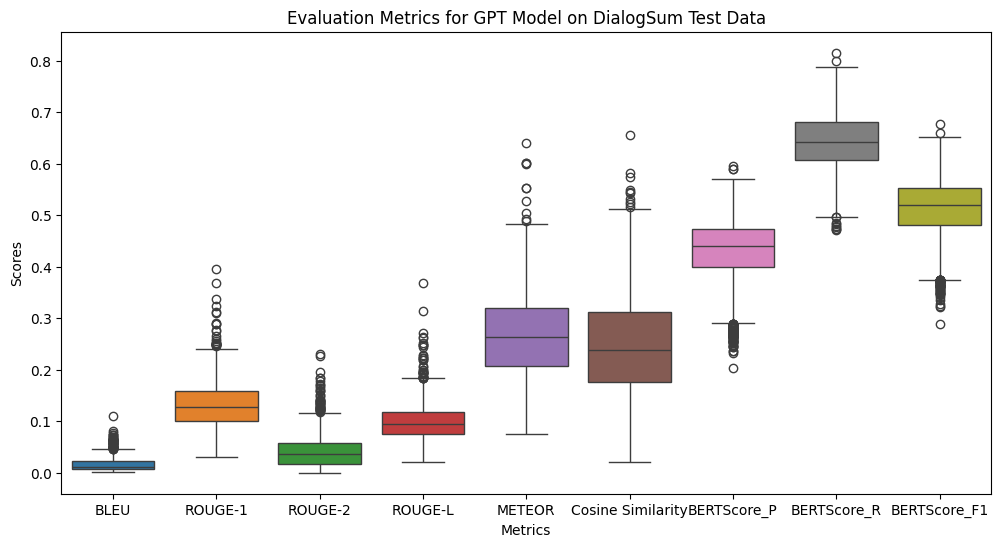

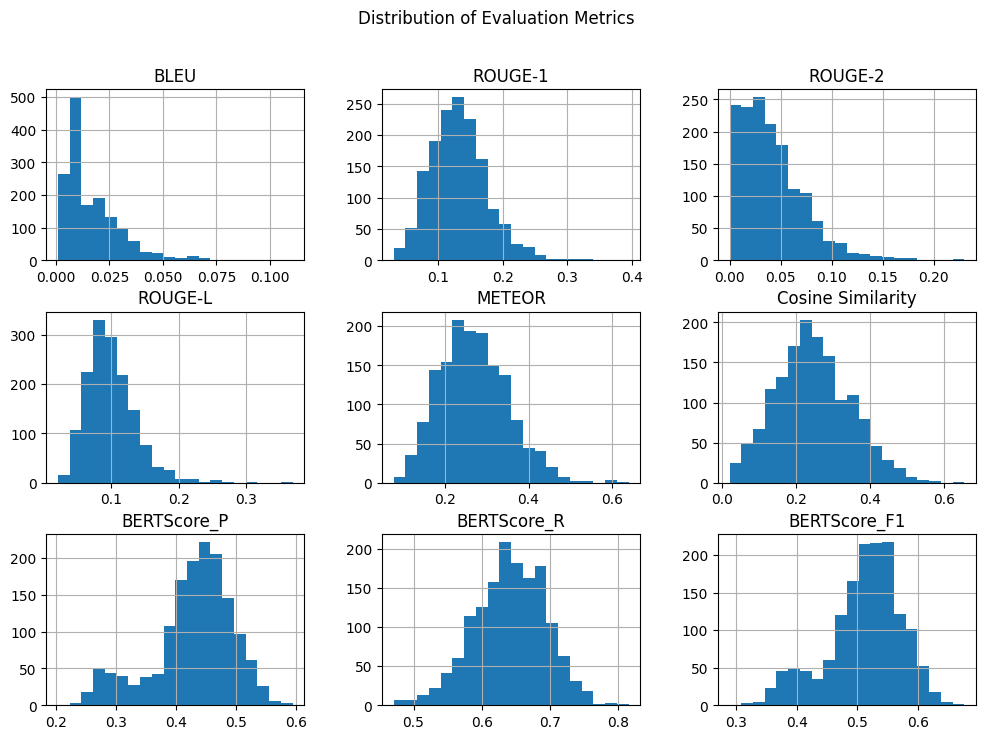

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']])
plt.title('Evaluation Metrics for GPT Model on DialogSum Test Data')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.show()

# Histograms
results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Evaluation Metrics')
plt.show()

#FINE TUNING GPT

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 req

In [ ]:
from datasets import load_dataset

# Loading dialogsum dataset
dataset_ft = load_dataset("knkarthick/dialogsum")
train_dataset_ft = dataset_ft['train']
val_dataset = dataset_ft['validation']
test_dataset = dataset_ft['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
print(dataset_ft)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


In [ ]:
dataset_ft['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"


def tokenize_function(examples):
    outputs = tokenizer(examples['dialogue'], padding="max_length", truncation=True)
    outputs['labels'] = outputs['input_ids'].copy()
    return outputs
tokenized_dataset = dataset_ft.map(tokenize_function, batched=True)

def model_init():
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.resize_token_embeddings(len(tokenizer))
    model.to(device)

    return model

Training on: cuda


Map:   0%|          | 0/12458 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
pip install optuna

In [ ]:
import optuna
from transformers import Trainer, TrainingArguments

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5)
    batch_size = trial.suggest_categorical('batch_size', [2, 4, 8])
    num_train_epochs = trial.suggest_int('num_train_epochs', 1, 5)

    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        fp16=True,
    )

    trainer = Trainer(
        model_init= model_init,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['validation'],
    )
    trainer.train()

In [ ]:

    eval_results = trainer.evaluate()
    return eval_results['eval_loss']

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
print(f'Best trial: {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

[I 2024-08-13 21:01:21,213] A new study created in memory with name: no-name-1bd4601a-c318-411e-bf1b-ff01eac22532
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.446100,0.424314
2,0.426800,0.419647


[I 2024-08-13 21:12:54,356] Trial 0 finished with value: 0.41964656114578247 and parameters: {'learning_rate': 1.502676322425725e-05, 'batch_size': 4, 'num_train_epochs': 2}. Best is trial 0 with value: 0.41964656114578247.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.436900,0.417223


[I 2024-08-13 21:20:22,787] Trial 1 finished with value: 0.41722312569618225 and parameters: {'learning_rate': 2.4739837342753377e-05, 'batch_size': 2, 'num_train_epochs': 1}. Best is trial 1 with value: 0.41722312569618225.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.427400,0.409998
2,0.391400,0.400381
3,0.380200,0.398920


[I 2024-08-13 21:42:16,927] Trial 2 finished with value: 0.3989200294017792 and parameters: {'learning_rate': 3.991015552692801e-05, 'batch_size': 2, 'num_train_epochs': 3}. Best is trial 2 with value: 0.3989200294017792.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.432200,0.413431
2,0.405000,0.407429


[I 2024-08-13 21:57:07,035] Trial 3 finished with value: 0.40742889046669006 and parameters: {'learning_rate': 2.6663585180517513e-05, 'batch_size': 2, 'num_train_epochs': 2}. Best is trial 2 with value: 0.3989200294017792.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.428400,0.410740


[I 2024-08-13 22:04:34,992] Trial 4 finished with value: 0.4107404947280884 and parameters: {'learning_rate': 4.71462888626257e-05, 'batch_size': 2, 'num_train_epochs': 1}. Best is trial 2 with value: 0.3989200294017792.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.426900,0.409630
2,0.389900,0.399805
3,0.378000,0.398383


[I 2024-08-13 22:26:46,891] Trial 5 finished with value: 0.39838334918022156 and parameters: {'learning_rate': 4.225524747182881e-05, 'batch_size': 2, 'num_train_epochs': 3}. Best is trial 5 with value: 0.39838334918022156.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.474100,0.437726


[I 2024-08-13 22:31:52,323] Trial 6 finished with value: 0.43772631883621216 and parameters: {'learning_rate': 1.1160601642383488e-05, 'batch_size': 8, 'num_train_epochs': 1}. Best is trial 5 with value: 0.39838334918022156.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.436500,0.417947
2,0.409500,0.408479
3,0.408100,0.404053
4,0.400100,0.402282
5,0.378900,0.401834


[I 2024-08-13 23:00:53,764] Trial 7 finished with value: 0.4018338620662689 and parameters: {'learning_rate': 2.5735739905217373e-05, 'batch_size': 4, 'num_train_epochs': 5}. Best is trial 5 with value: 0.39838334918022156.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.434300,0.416280
2,0.405500,0.406273
3,0.402100,0.401578
4,0.392400,0.399853
5,0.370300,0.399604


[I 2024-08-13 23:29:59,864] Trial 8 finished with value: 0.39960378408432007 and parameters: {'learning_rate': 3.1585827845998326e-05, 'batch_size': 4, 'num_train_epochs': 5}. Best is trial 5 with value: 0.39838334918022156.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.433900,0.415942
2,0.404900,0.406000
3,0.401300,0.401255
4,0.391400,0.399551
5,0.369100,0.399330


[I 2024-08-13 23:59:00,940] Trial 9 finished with value: 0.39933037757873535 and parameters: {'learning_rate': 3.233878674697957e-05, 'batch_size': 4, 'num_train_epochs': 5}. Best is trial 5 with value: 0.39838334918022156.


Best trial: 0.39838334918022156
Best hyperparameters: {'learning_rate': 4.225524747182881e-05, 'batch_size': 2, 'num_train_epochs': 3}


In [ ]:
best_trial = study.best_trial
print(f'Best trial: {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

Best trial: 0.39838334918022156
Best hyperparameters: {'learning_rate': 4.225524747182881e-05, 'batch_size': 2, 'num_train_epochs': 3}


In [ ]:
'''import torch

# Clear GPU cache
torch.cuda.empty_cache()'''

Best hyperparameters: {'learning_rate': 4.225524747182881e-05, 'batch_size': 2, 'num_train_epochs': 3}

In [ ]:
best_params = study.best_trial.params

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    num_train_epochs=best_params['num_train_epochs'],
    weight_decay=0.01,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.427000,0.409739
2,0.389900,0.399837
3,0.378100,0.398407


TrainOutput(global_step=18687, training_loss=0.4124250646233846, metrics={'train_runtime': 1330.6051, 'train_samples_per_second': 28.088, 'train_steps_per_second': 14.044, 'total_flos': 1.9531056807936e+16, 'train_loss': 0.4124250646233846, 'epoch': 3.0})

In [ ]:
pip install pynvml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.6 MB/s eta 0:00:00


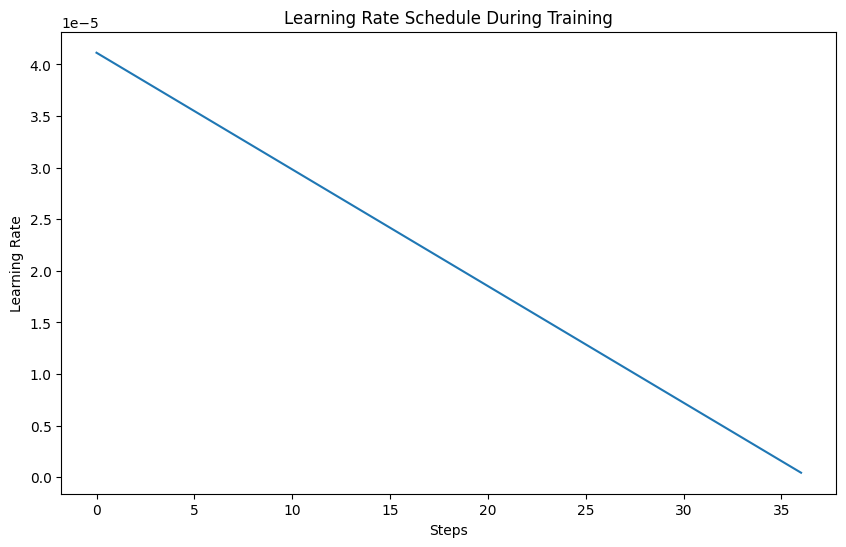

In [ ]:
import matplotlib.pyplot as plt

learning_rates = [entry['learning_rate'] for entry in trainer.state.log_history if 'learning_rate' in entry]
steps = range(len(learning_rates))

plt.figure(figsize=(10, 6))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule During Training")
plt.show()

In [ ]:
torch.save(trainer.model.state_dict(), "fine-tuned-GPT2.pt")

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Loading the finetuned model and tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))
model.load_state_dict(torch.load("/content/fine-tuned-GPT2.pt"))
model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
def tokenize_function(examples):
    outputs = tokenizer(examples['dialogue'], padding="max_length", truncation=True)
    outputs['labels'] = outputs['input_ids'].copy()
    return outputs

tokenized_test_dataset = dataset_ft['test'].map(tokenize_function, batched=True)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
def generate_summary_batch(examples):
    input_texts = examples['dialogue']
    inputs = tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        output_ids = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=150, num_beams=4, early_stopping=True, pad_token_id=tokenizer.pad_token_id)

    summaries = [tokenizer.decode(g, skip_special_tokens=True) for g in output_ids]
    return {"generated_summary": summaries}

batch_size = 8
test_dataset = test_dataset.map(generate_summary_batch, batched=True, batch_size=batch_size)


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c60dbe1d155946cd4b9cdb1a135d2a27c71f38e3b7b6350c453e6c4eab54c188
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
pip install bert_score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def calculate_metrics(reference, hypothesis):
    metrics = {}

    reference_tokens = nltk.word_tokenize(reference)
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    smooth_fn = SmoothingFunction().method1#BLEU
    metrics['BLEU'] = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    metrics['ROUGE-1'] = rouge_scores['rouge1'].fmeasure
    metrics['ROUGE-2'] = rouge_scores['rouge2'].fmeasure
    metrics['ROUGE-L'] = rouge_scores['rougeL'].fmeasure
    metrics['METEOR'] = meteor_score([reference_tokens], hypothesis_tokens)
    P, R, F1 = bert_score([hypothesis], [reference], lang='en', model_type='bert-base-uncased', verbose=False)
    metrics['BERTScore_P'] = P.mean().item()
    metrics['BERTScore_R'] = R.mean().item()
    metrics['BERTScore_F1'] = F1.mean().item()

    vectorizer = TfidfVectorizer().fit_transform([reference, hypothesis])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors)
    metrics['Cosine Similarity'] = cosine_sim[0, 1]

    return metrics

test_results = test_dataset.map(lambda example: calculate_metrics(example['summary'], example['generated_summary']))
#results
results_df = pd.DataFrame(test_results)
print(f"Evaluation Metrics for GPT2 Model\n")
print(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'Cosine Similarity', 'BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].describe())

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Evaluation Metrics for BART Model

              BLEU      ROUGE-1      ROUGE-2      ROUGE-L       METEOR  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean      0.015939     0.124289     0.039021     0.093888     0.256841   
std       0.012414     0.041238     0.030740     0.033723     0.076219   
min       0.000908     0.024540     0.000000     0.022727     0.057915   
25%       0.007080     0.093750     0.016393     0.069823     0.199911   
50%       0.010954     0.121760     0.033333     0.089172     0.252261   
75%       0.022294     0.150289     0.054795     0.112274     0.305116   
max       0.081091     0.310559     0.226415     0.260870     0.560897   

       Cosine Similarity  BERTScore_P  BERTScore_R  BERTScore_F1  
count        1500.000000  1500.000000  1500.000000   1500.000000  
mean            0.250199     0.425286     0.641220      0.509156  
std             0.101655     0.065548     0.052138      0.060070  
min             0.019077     0

In [ ]:
results_df = pd.DataFrame(test_results)
print(f"Evaluation Metrics for GPT2 Model\n")
print(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'Cosine Similarity', 'BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].describe())

Evaluation Metrics for GPT2 Model

              BLEU      ROUGE-1      ROUGE-2      ROUGE-L       METEOR  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean      0.015939     0.124289     0.039021     0.093888     0.256841   
std       0.012414     0.041238     0.030740     0.033723     0.076219   
min       0.000908     0.024540     0.000000     0.022727     0.057915   
25%       0.007080     0.093750     0.016393     0.069823     0.199911   
50%       0.010954     0.121760     0.033333     0.089172     0.252261   
75%       0.022294     0.150289     0.054795     0.112274     0.305116   
max       0.081091     0.310559     0.226415     0.260870     0.560897   

       Cosine Similarity  BERTScore_P  BERTScore_R  BERTScore_F1  
count        1500.000000  1500.000000  1500.000000   1500.000000  
mean            0.250199     0.425286     0.641220      0.509156  
std             0.101655     0.065548     0.052138      0.060070  
min             0.019077     0

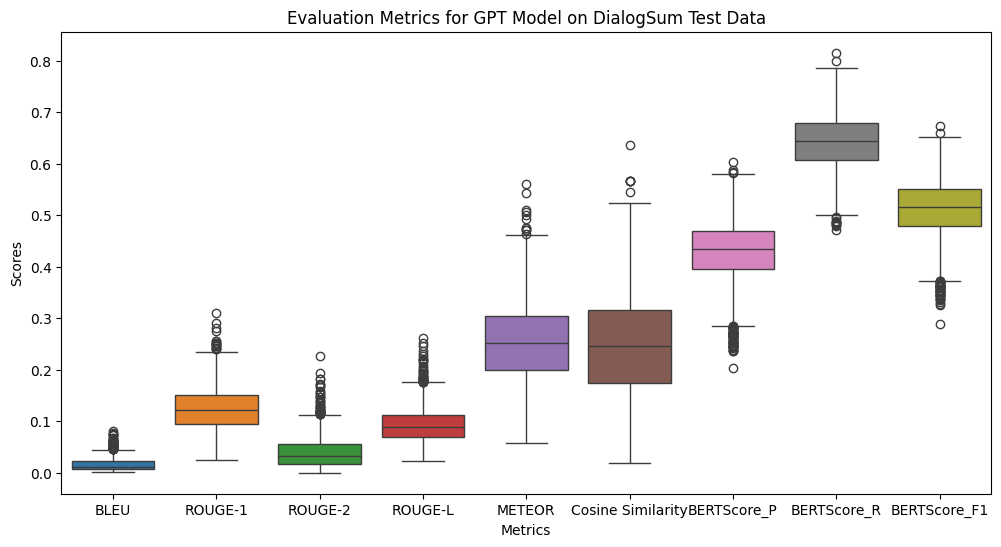

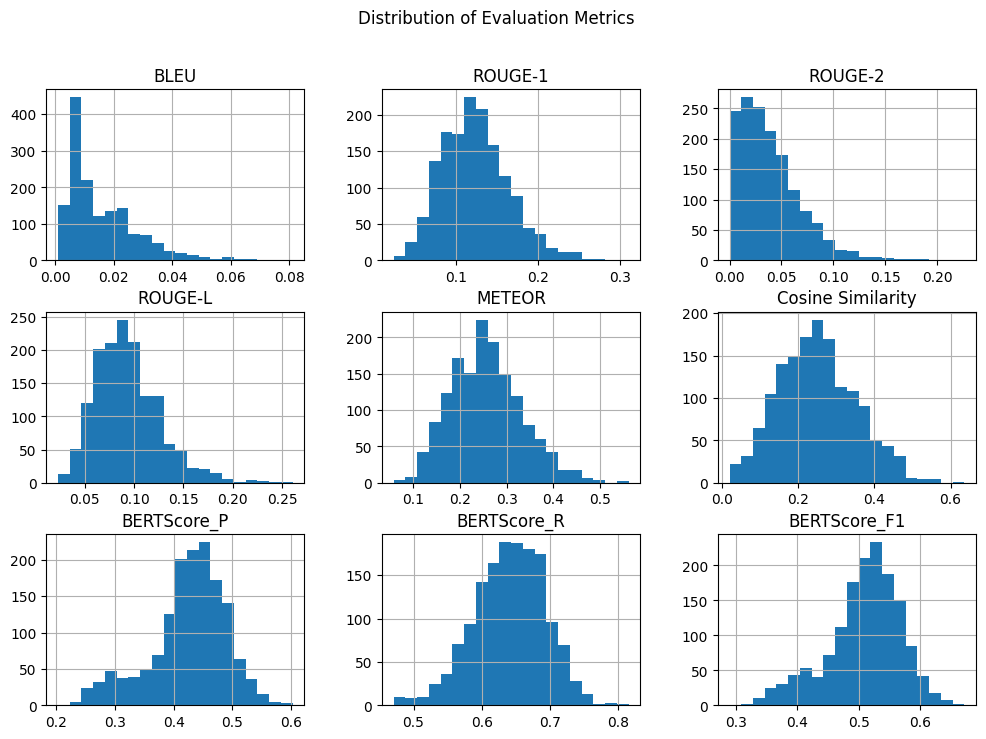

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']])
plt.title('Evaluation Metrics for GPT Model on DialogSum Test Data')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.show()

# Histograms
results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Evaluation Metrics')
plt.show()